# MNIST

In [ ]:
#공통 모듈 임포트
import numpy as np
import os

#노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

#깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes',labelsize=14)
mpl.rc('xtick',labelsize=12)
mpl.rc('ytick',labelsize=12)

In [ ]:
from sklearn.datasets import fetch_openml
mnist=fetch_openml('mnist_784',version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [ ]:
X,y=mnist["data"],mnist["target"]
X.shape

(70000, 784)

In [ ]:
y.shape

(70000,)

In [ ]:
28*28

784

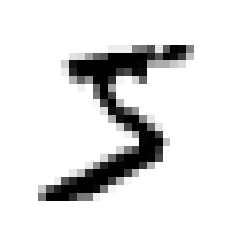

In [ ]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit=X[0]
some_digit_image=some_digit.reshape(28,28)
plt.imshow(some_digit_image,cmap=mpl.cm.binary)
plt.axis("off")

plt.show()

In [ ]:
y[0]

'5'

In [ ]:
y=y.astype(np.uint8)

In [ ]:
def plot_digit(data):
  image=data.reshape(28,28)
  plt.imshow(image,cmap=mpl.cm.binary,interpolation="nearest")
  plt.axis("off")

In [ ]:
#숫자 그림을 위한 추가 함수
def plot_digits(instances,images_per_row=10,**options):
  size=28
  images_per_row=min(len(instances),images_per_row)
  images=[instance.reshape(size,size)for instance in instances]
  n_rows=(len(instances)-1)//images_per_row+1
  row_images=[]
  n_empty=n_rows*images_per_row-len(instances)
  images.append(np.zeros((size,size*n_empty)))
  for row in range(n_rows):
    rimages=images[row*images_per_row:(row+1)*images_per_row]
    row_images.append(np.concatenate(rimages,axis=1))
  image=np.concatenate(row_images,axis=0)
  plt.imshow(image,cmap=mpl.cm.binary,**options)
  plt.axis("off")

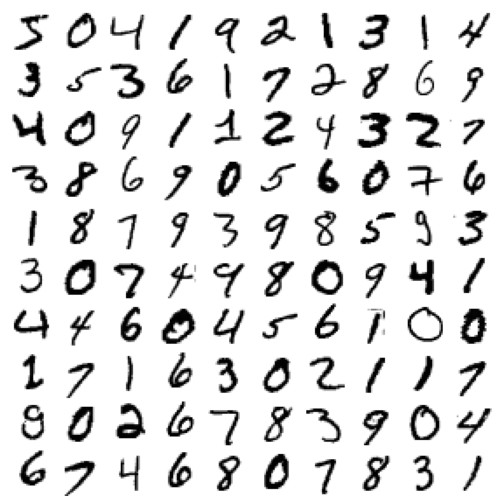

In [ ]:
plt.figure(figsize=(9,9))
example_images=X[:100]
plot_digits(example_images,images_per_row=10)
plt.show()

In [ ]:
y[0]

5

In [ ]:
X_train,X_test,y_train,y_test=X[:60000],X[60000:],y[:60000],y[60000:]

## 이진 분류기 훈련

In [ ]:
y_train_5=(y_train==5)
y_test_5=(y_test==5)

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf=SGDClassifier(max_iter=1000,tol=1e-3,random_state=42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
sgd_clf.predict([some_digit])

array([ True])

## 성능 측정

### 교차 검증을 사용한 정확도 측정

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds=StratifiedKFold(n_splits=3,random_state=42,shuffle=True)

for train_index,test_index in skfolds.split(X_train,y_train_5):
  clone_clf=clone(sgd_clf)
  X_train_folds=X_train[train_index]
  y_train_folds=y_train_5[train_index]
  X_test_fold=X_train[test_index]
  y_test_fold=y_train_5[test_index]

  clone_clf.fit(X_train_folds,y_train_folds)
  y_pred=clone_clf.predict(X_test_fold)
  n_correct=sum(y_pred==y_test_fold)
  print(n_correct/len(y_pred))

0.9669
0.91625
0.96785


In [ ]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
  def fit(self,X,y=None):
    pass
  def predict(self,X):
    return np.zeros((len(X),1),dtype=bool)

In [ ]:
never_5_clf=Never5Classifier()
cross_val_score(never_5_clf,X_train,y_train_5,cv=3,scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

### 오차 행렬

In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred=cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5,y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [ ]:
y_train_perfect_predictions=y_train_5 #완벽한 분류기일 경우
confusion_matrix(y_train_5,y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

### 정밀도와 재현율

In [ ]:
from sklearn.metrics import precision_score,recall_score

precision_score(y_train_5,y_train_pred)

0.8370879772350012

In [ ]:
cm=confusion_matrix(y_train_5,y_train_pred)
cm[1,1]/(cm[0,1]+cm[1,1])

0.8370879772350012

In [ ]:
recall_score(y_train_5,y_train_pred)

0.6511713705958311

In [ ]:
cm[1,1]/(cm[1,0]+cm[1,1])

0.6511713705958311

In [ ]:
from sklearn.metrics import f1_score

f1_score(y_train_5,y_train_pred)

0.7325171197343846

In [ ]:
cm[1,1]/(cm[1,1]+(cm[1,0]+cm[0,1])/2)

0.7325171197343847

### 정밀도/재현율 트레이드오프

In [ ]:
y_scores=sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [ ]:
threshold=0
y_some_digit_pred=(y_scores>threshold)

In [ ]:
y_some_digit_pred

array([ True])

In [ ]:
threshold=8000
y_some_digit_pred=(y_scores>threshold)
y_some_digit_pred

array([False])

In [ ]:
y_scores=cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method="decision_function")

In [ ]:
from sklearn.metrics import precision_recall_curve

precisions,recalls,thresholds=precision_recall_curve(y_train_5,y_scores)

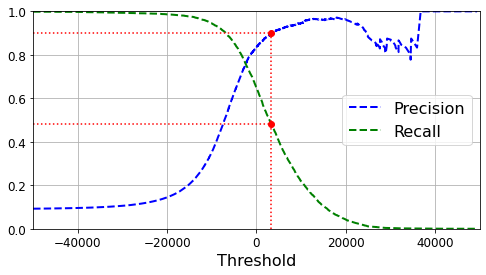

In [ ]:
def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
  plt.plot(thresholds,precisions[:-1],"b--",label="Precision",linewidth=2)
  plt.plot(thresholds,recalls[:-1],"g--",label="Recall",linewidth=2)
  plt.legend(loc="center right",fontsize=16)
  plt.xlabel("Threshold",fontsize=16)
  plt.grid(True)
  plt.axis([-50000,50000,0,1])

recall_90_precision=recalls[np.argmax(precisions>=0.90)]
threshold_90_precision=thresholds[np.argmax(precisions>=0.90)]

plt.figure(figsize=(8,4))
plot_precision_recall_vs_threshold(precisions,recalls,thresholds)
plt.plot([threshold_90_precision,threshold_90_precision],[0.,0.9],"r:")
plt.plot([-50000,threshold_90_precision],[0.9,0.9],"r:")
plt.plot([-50000,threshold_90_precision],[recall_90_precision,recall_90_precision],"r:")
plt.plot([threshold_90_precision],[0.9],"ro")
plt.plot([threshold_90_precision],[recall_90_precision],"ro")
plt.show()

In [ ]:
(y_train_pred==(y_scores>0)).all()

True

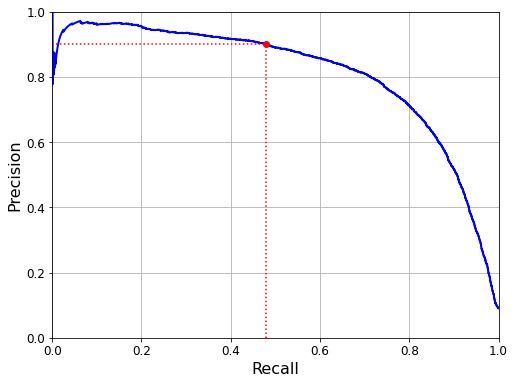

In [ ]:
def plot_precision_vs_recall(precisions,recalls):
  plt.plot(recalls,precisions,"b-",linewidth=2)
  plt.xlabel("Recall",fontsize=16)
  plt.ylabel("Precision",fontsize=16)
  plt.axis([0,1,0,1])
  plt.grid(True)

plt.figure(figsize=(8,6))
plot_precision_vs_recall(precisions,recalls)
plt.plot([recall_90_precision,recall_90_precision],[0.,0.9],"r:")
plt.plot([0.0,recall_90_precision],[0.9,0.9],"r:")
plt.plot([recall_90_precision],[0.9],"ro")
plt.show()

In [ ]:
threshold_90_precision=thresholds[np.argmax(precisions>=0.90)]

In [ ]:
threshold_90_precision

3370.0194991439557

In [ ]:
y_train_pred_90=(y_scores>=threshold_90_precision)

In [ ]:
precision_score(y_train_5,y_train_pred_90)

0.9000345901072293

In [ ]:
recall_score(y_train_5,y_train_pred_90)

0.4799852425751706

### ROC 곡선

In [ ]:
from sklearn.metrics import roc_curve

fpr,tpr,thresholds=roc_curve(y_train_5,y_scores)

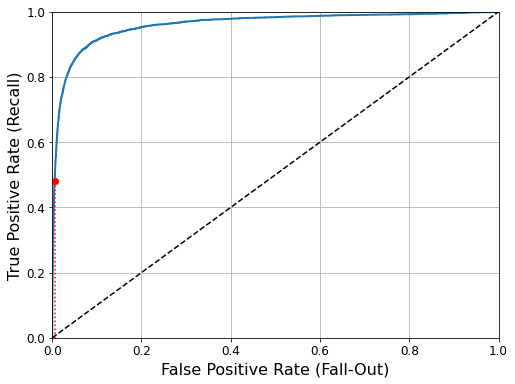

In [ ]:
def plot_roc_curve(fpr,tpr,label=None):
  plt.plot(fpr,tpr,linewidth=2,label=label)
  plt.plot([0,1],[0,1],'k--')  #대각 점선
  plt.axis([0,1,0,1])
  plt.xlabel('False Positive Rate (Fall-Out)',fontsize=16)
  plt.ylabel('True Positive Rate (Recall)',fontsize=16)
  plt.grid(True)

plt.figure(figsize=(8,6))
plot_roc_curve(fpr,tpr)
fpr_90=fpr[np.argmax(tpr>=recall_90_precision)]
plt.plot([fpr_90,fpr_90],[0.,recall_90_precision],"r:")
plt.plot([0.0,fpr_90],[recall_90_precision,recall_90_precision],"r:")
plt.plot([fpr_90],[recall_90_precision],"ro")
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5,y_scores)

0.9604938554008616

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest_clf=RandomForestClassifier(n_estimators=100,random_state=42)
y_probas_forest=cross_val_predict(forest_clf,X_train,y_train_5,cv=3,method="predict_proba")

In [ ]:
y_scores_forest=y_probas_forest[:,1]  #점수 = 양성 클래스의 확률
fpr_forest,tpr_forest,thresholds_forest=roc_curve(y_train_5,y_scores_forest)

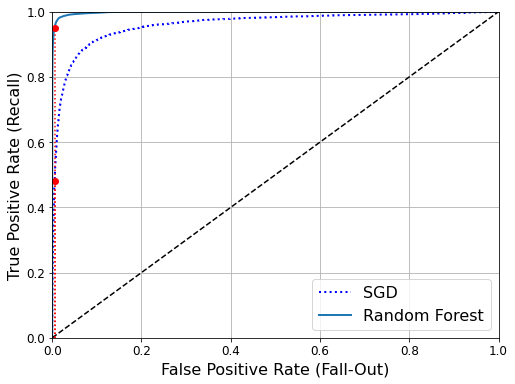

In [ ]:
recall_for_forest=tpr_forest[np.argmax(fpr_forest>=fpr_90)]

plt.figure(figsize=(8,6))
plt.plot(fpr,tpr,"b:",linewidth=2,label="SGD")
plot_roc_curve(fpr_forest,tpr_forest,"Random Forest")
plt.plot([fpr_90,fpr_90],[0.,recall_90_precision],"r:")
plt.plot([0.0,fpr_90],[recall_90_precision,recall_90_precision],"r:")
plt.plot([fpr_90],[recall_90_precision],"ro")
plt.plot([fpr_90,fpr_90],[0.,recall_for_forest],"r:")
plt.plot([fpr_90],[recall_for_forest],"ro")
plt.grid(True)
plt.legend(loc="lower right",fontsize=16)
plt.show()

In [ ]:
roc_auc_score(y_train_5,y_scores_forest)

0.9983436731328145

In [ ]:
y_train_pred_forest=cross_val_predict(forest_clf,X_train,y_train_5,cv=3)
precision_score(y_train_5,y_train_pred_forest)

0.9905083315756169

In [ ]:
recall_score(y_train_5,y_train_pred_forest)

0.8662608374838591

## 다중 분류

In [ ]:
from sklearn.svm import SVC

svm_clf=SVC(gamma="auto",random_state=42)
svm_clf.fit(X_train[:1000],y_train[:1000])  #y_train_5가 아니고 y_train을 사용
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [ ]:
some_digit_scores=svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [ ]:
np.argmax(some_digit_scores)

5

In [ ]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
svm_clf.classes_[5]

5

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf=OneVsRestClassifier(SVC(gamma="auto",random_state=42))
ovr_clf.fit(X_train[:1000],y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [ ]:
len(ovr_clf.estimators_)

10

In [ ]:
sgd_clf.fit(X_train,y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [ ]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [ ]:
cross_val_score(sgd_clf,X_train,y_train,cv=3,scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf,X_train_scaled,y_train,cv=3,scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## 에러 분석

In [ ]:
y_train_pred=cross_val_predict(sgd_clf,X_train_scaled,y_train,cv=3)
conf_mx=confusion_matrix(y_train,y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

In [ ]:
def plot_cunfusion_matrix(matrix):
  """If you prefer color and a colorbar"""
  fig=plt.figure(figsize=(8,8))
  ax=fig.add_subplot(111)
  cax=ax.matshow(matrix)
  fig.colorbar(cax)

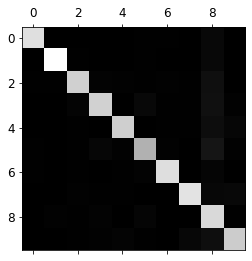

In [ ]:
plt.matshow(conf_mx,cmap=plt.cm.gray)
plt.show()

In [ ]:
row_sums=conf_mx.sum(axis=1,keepdims=True)
norm_conf_mx=conf_mx/row_sums

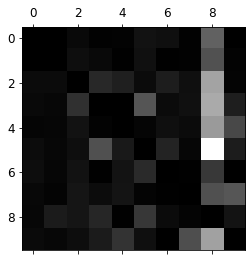

In [ ]:
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx,cmap=plt.cm.gray)
plt.show()

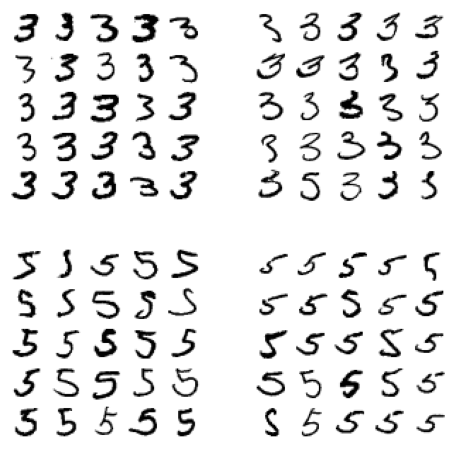

In [ ]:
cl_a,cl_b=3,5
X_aa=X_train[(y_train==cl_a)&(y_train_pred==cl_a)]
X_ab=X_train[(y_train==cl_a)&(y_train_pred==cl_b)]
X_ba=X_train[(y_train==cl_b)&(y_train_pred==cl_a)]
X_bb=X_train[(y_train==cl_b)&(y_train_pred==cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25],images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25],images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25],images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25],images_per_row=5)
plt.show()

## 다중 레이블 분류

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large=(y_train>=7)
y_train_odd=(y_train%2==1)
y_multilabel=np.c_[y_train_large,y_train_odd]

knn_clf=KNeighborsClassifier()
knn_clf.fit(X_train,y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [ ]:
y_train_knn_pred=cross_val_predict(knn_clf,X_train,y_multilabel,cv=3)
f1_score(y_multilabel,y_train_knn_pred,average="macro")

0.976410265560605

## 다중 출력 분류

In [ ]:
noise=np.random.randint(0,100,(len(X_train),784))
X_train_mod=X_train+noise
noise=np.random.randint(0,100,(len(X_test),784))
X_test_mod=X_test+noise
y_train_mod=X_train
y_test_mod=X_test

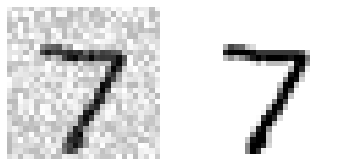

In [ ]:
some_index=0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

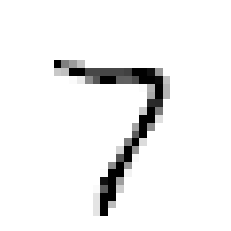

In [ ]:
knn_clf.fit(X_train_mod,y_train_mod)
clean_digit=knn_clf.predict([X_test_mod[some_index]])
plot_digits(clean_digit)